# Neural Network (MLP) Implementation


# Imports

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Utility Functions

## Metrics and Loss Functions

In [5]:
def accuracy(y_true, y_pred):

    if(len(y_true.shape) == 1):
        y_true = y_true.reshape(-1, 1)
    if(len(y_pred.shape) == 1):
        y_pred = y_pred.reshape(-1, 1)

    right_prediction = y_true == y_pred
    right_prediction = np.all(right_prediction, axis=1)

    accuracy = right_prediction.sum() / len(y_true)
    return accuracy


def cross_entropy_loss(y_true, y_pred_proba):
    return -np.sum(y_true * np.log(y_pred_proba)) / y_true.shape[0]


def mse(y_true, y_pred):
    y_true = y_true.reshape(-1, 1)
    y_pred = y_pred.reshape(-1, 1)
    return np.mean((y_true - y_pred)**2)


def rmse(y_true, y_pred):
    y_true = y_true.reshape(-1, 1)
    y_pred = y_pred.reshape(-1, 1)
    return np.sqrt(mse(y_true, y_pred))


def mae(y_true, y_pred):
    y_true = y_true.reshape(-1, 1)
    y_pred = y_pred.reshape(-1, 1)
    return np.mean(np.abs(y_true - y_pred))


def mre(y_true, y_pred):
    y_true = y_true.reshape(-1, 1)
    y_pred = y_pred.reshape(-1, 1)
    return np.mean(np.abs((y_true - y_pred)/y_true))

In [6]:
import pandas as pd

def get_regression_metrics(y_true, y_pred, index=''):
    return pd.DataFrame([
        {
            'MSE': mse(y_true, y_pred),
            'RMSE': rmse(y_true, y_pred),
            'MAE': mae(y_true, y_pred),
            'MRE': mre(y_true, y_pred)
        }
    ], index=[index])

def get_classification_metrics(y_true, y_pred, index=''):
    return pd.DataFrame([
        {
            'Accuracy': accuracy(y_true, y_pred)
        }
    ], index=[index])


## MinMaxScaler

In [7]:
class MinMaxScaler:
    def __init__(self):
        self.fitted = False

    def fit_transform(self, data):      
        self.maximum = data.max(axis=0)
        self.minimum = data.min(axis=0)
        self.fitted = True

        scaled_data =  (data - self.minimum) / (self.maximum - self.minimum)
        return scaled_data
    
    def transform(self, data):
        if not self.fitted:
            raise Exception('Scaler not fitted!')

        scaled_data =  (data - self.minimum) / (self.maximum - self.minimum)
        return scaled_data

    def inverse_transform(self, scaled_data):
        if not self.fitted:
            raise Exception('Scaler not fitted!')
        
        original_data = (self.maximum - self.minimum) * scaled_data + self.minimum
        return original_data

## Train Test Split

In [8]:
def train_test_split(X, y, train_size_perc, random_seed=264852):
    
    y = y.reshape(-1, 1)
    
    N = X.shape[0]
    train_size = int(train_size_perc * N)

    indexes = np.arange(0, N, 1)

    np.random.seed(random_seed)
    train_idx = np.random.choice(indexes, train_size, replace=False)
    test_idx = np.delete(indexes, train_idx)

    X_train = X[train_idx, :]
    y_train = y[train_idx, :]
    X_test = X[test_idx, :]
    y_test = y[test_idx, :]

    return X_train, X_test, y_train, y_test


## Activation Functions 

In [6]:
class Sigmoid():
    @staticmethod
    def get_value(x):
        return 1/(1+np.exp(-x))

    @staticmethod
    def get_derivative(x):
        return Sigmoid.get_value(x) - Sigmoid.get_value(x)**2


class TanH:
    @staticmethod
    def get_value(x):
        return (np.exp(2*x) - 1) / (np.exp(2*x) + 1)

    @staticmethod
    def get_derivative(x):
        return 1 - TanH().get_value(x) ** 2


class ReLU():
    @staticmethod
    def get_value(x):
        return np.maximum(0, x)

    @staticmethod
    def get_derivative(x):
        return np.where(x <= 0, 0, 1)


class Identity():
    @staticmethod
    def get_value(x):
        return np.ones(x.shape) * x

    @staticmethod
    def get_derivative(x):
        return np.ones(x.shape)


class Softmax():
    @staticmethod
    def get_value(x):
        return np.exp(x)/np.sum(np.exp(x), axis=1).reshape(-1, 1)

# MLP Implementation (Regression and Classification)

In [7]:
class MyMLP():

    def __init__(self, loss_function, output_activation_function, verbose=False):
        self.fitted = False
        self.n_hidden = []
        self.activation_functions = [Identity(), output_activation_function]
        self.verbose=verbose
        self.best_epoch = None
        self.loss_function = loss_function
        
        
    def add_hidden_layer(self, n_neurons, activation_function):
        self.n_hidden.append(n_neurons)
        self.activation_functions = self.activation_functions[:-1] \
            + [activation_function] \
            + [self.activation_functions[-1]]


    def initialize_weights(self, X, y, random_state=None):
        self.weights = []

        if random_state is None:
            seed = np.random.RandomState()
        else:
            seed = np.random.RandomState(random_state)

        self.layers = [X.shape[1]] + self.n_hidden + [y.shape[1]]
        
        for i in range(len(self.layers)-1):
            # Weight initialization strategies
            if type(self.activation_functions[i]) == ReLU:
                w = seed.normal(
                    size = (self.layers[i+1], self.layers[i])
                ) * np.sqrt(2/self.layers[i+1])  
                w = np.hstack([np.ones((self.layers[i+1], 1))*0.01, w])
            else:
                w = seed.normal(
                    size = (self.layers[i+1], self.layers[i])
                ) * np.sqrt(1/self.layers[i+1])
                w = np.hstack([np.zeros((self.layers[i+1], 1)), w])               

            self.weights.append(w)

        self.momentum_weights = [np.zeros_like(w) for w in self.weights]


    def forward_propagation(self, X):
        input = np.hstack(
            [np.ones((X.shape[0],1)), X]
        )

        # Input of the i-th layer
        self.layer_inputs = []
        # Output of the i-th layer 
        self.layer_outputs = []

        self.layer_inputs.append(input)
        self.layer_outputs.append(input)
        
        # Calculating input of next layer
        for i, w in enumerate(self.weights):
            activation_function = self.activation_functions[i+1]            
            
            self.layer_inputs.append(input)

            # Calculating input of next layer
            output = np.array(input @ w.T)

            # Passing values through the activation function of next layer
            activated_output = activation_function.get_value(output)
            
            if i < len(self.weights)-1:
                activated_output = np.hstack(
                    [np.ones((X.shape[0],1)), activated_output]
                )
            self.layer_outputs.append(activated_output)
            input = activated_output

        return activated_output # Output


    def back_propagation(self, error, learning_rate, momentum_factor=0):
        output_layer = True
        self.deltas = []
        
        # Calculating deltas
        for i in range(len(self.activation_functions)-1, 0, -1):
            act_function = self.activation_functions[i]
            
            if output_layer:
                delta_i = error
                self.deltas = [delta_i] + self.deltas
                output_layer=False
            else:
                layer_outputs = self.layer_outputs[i][:, 1:]
                weights = self.weights[i][:, 1:]
                delta_i = act_function.get_derivative(layer_outputs) \
                    * (self.deltas[0] @ weights)
                self.deltas = [delta_i] + self.deltas

        # Updating weights
        for i in range(len(self.weights)):
            gradient = (self.deltas[i].T @ self.layer_outputs[i]) / len(error)
            update_factor = (learning_rate * gradient) + (momentum_factor * self.momentum_weights[i])
            self.weights[i] -= update_factor
            self.momentum_weights[i] = update_factor
            

    def get_minibatches(self, X, y, batch_size):
        init_index=0
        batches = []

        for final_index in range(batch_size, X.shape[0]+batch_size, batch_size):
            
            X_minibatch = X[init_index:final_index]
            y_minibatch = y[init_index:final_index]

            init_index = final_index
            batches.append((X_minibatch, y_minibatch))
        
        return batches


    def fit(
        self, 
        X, 
        y, 
        learning_rate=0.1,
        early_stopping_rounds=None,
        valid_set=None, 
        epochs=100, 
        batch_size=32, 
        momentum_factor=0,
        random_state=None,
        random_state_shuffle=None,
        **kwargs
    ):
        
        self.initialize_weights(X, y, random_state)
        
        self.loss_function_curve = []
        self.loss_function_curve_val = []

        train_indexes = np.arange(X.shape[0], dtype=int)

        # Initializing early stopping variables
        if early_stopping_rounds is not None:
            count_early_stopping = 0
            best_mse = np.inf

        # Training model
        for i, epochs in enumerate(range(epochs)):
            loss_function = 0
            val_loss_function = 0

            seed = np.random.RandomState(random_state_shuffle)
            seed.shuffle(train_indexes) # inplace
            X = X[train_indexes]
            y = y[train_indexes]
            
            batches = self.get_minibatches(X, y, batch_size)
            
            # Iterating through the minibatches
            for j, (input, output) in enumerate(batches):
                y_pred = self.forward_propagation(input)
                    
                error = y_pred - output

                self.back_propagation(
                    error=error, 
                    learning_rate=learning_rate,
                    momentum_factor=momentum_factor
                )

                if valid_set is not None:
                    X_val_it, y_val_it = valid_set[0], valid_set[1]
                    y_val_pred = self.predict_proba(X_val_it)
                    val_iteration_metric = self.loss_function(y_val_it, y_val_pred)

                    # Multiplying by the number of records to weight the 
                    # mse mean at the end of the epoch
                    val_loss_function+=val_iteration_metric
                            

                # Multiplying by the number of records to weight the 
                # mse mean at the end of the epoch
                loss_function+=self.loss_function(output, y_pred)*input.shape[0]            
            
            self.loss_function_curve.append(loss_function/X.shape[0])

            if valid_set is not None:
                loss_valid_epoch = val_loss_function/len(batches)
                self.loss_function_curve_val.append(loss_valid_epoch)
                if self.verbose:
                    if i % self.verbose == 0:
                        print('Epoch {:>4} -> Loss Function: Train {:.6f} | \
Valid {:.6f}'.format(
                                i,
                                loss_function/X.shape[0],
                                loss_valid_epoch
                            )
                        )
            else:
                if self.verbose:
                    if i % self.verbose == 0:
                        print(
                            f'Epoch {i} | Loss Function: ', 
                            loss_function/X.shape[0]
                        )
                    
            if early_stopping_rounds is not None:
                if val_loss_function/X.shape[0] <= best_mse:
                    best_mse = val_loss_function/X.shape[0]
                    best_weights = self.weights
                    self.best_epoch = i
                    count_early_stopping = 0
                else:
                    count_early_stopping += 1

                    if count_early_stopping >= early_stopping_rounds:
                        try:
                            self.weights = best_weights
                            print(f'-> Early stopping has been activated! Best \
epoch: {self.best_epoch}')
                            break
                        except UnboundLocalError as error:
                            print('Convergence error. Ignoring this trial.')
                            break
        self.fitted = True


    def plot_learning_curve(self):
        plt.figure(figsize=(14, 8))
        plt.plot(self.loss_function_curve, label='Train')

        if len(self.loss_function_curve_val)>0:
            plt.plot(self.loss_function_curve_val, label='Validation')
        
        if self.best_epoch is not None:
            plt.axvline(
                self.best_epoch, 
                linestyle='--', 
                color='green', 
                label='Best epoch'
            )

        plt.title('Learning Curves', fontsize=18)
        plt.legend()


    def predict_proba(self, X):
        if self.fitted:
            input = np.hstack(
                [np.ones((X.shape[0],1)), X]
            )

            for i, w in enumerate(self.weights):
                activation_function = self.activation_functions[i+1]            
                
                # Calculating input of next layer
                output = np.array(input @ w.T)

                # Passing values through the activation function of next layer
                activated_output = activation_function.get_value(output)
                
                # Do not append the column with ones in the last layer
                if i < len(self.weights)-1:
                    activated_output = np.hstack(
                        [np.ones((X.shape[0],1)), activated_output]
                    )
                input = activated_output

            return activated_output
        else:
            print('The model is not fitted!')


    def predict(self, X):
        if self.fitted:
            # If classification task, do one hot encoding on result
            if isinstance(self.activation_functions[-1], (Sigmoid, Softmax)):
                    preds = self.predict_proba(X)
                    preds = np.argmax(preds, axis=1)
                    preds = preds.astype(int).ravel()
                    preds_ohe = np.zeros((preds.size, self.layers[-1]))
                    preds_ohe[np.arange(preds.size), preds] = 1
                    return preds_ohe
            else:
                return self.predict_proba(X)
        else:
            print('The model is not fitted!')


# MLP (Regression)

In [8]:
data = np.genfromtxt('../data/concrete.csv', delimiter=',')
X = data[:, :-1]
y = data[:, -1]
print('Shape:', data.shape)
data[:3, :]


Shape: (1030, 9)


array([[ 540.  ,    0.  ,    0.  ,  162.  ,    2.5 , 1040.  ,  676.  ,
          28.  ,   79.99],
       [ 540.  ,    0.  ,    0.  ,  162.  ,    2.5 , 1055.  ,  676.  ,
          28.  ,   61.89],
       [ 332.5 ,  142.5 ,    0.  ,  228.  ,    0.  ,  932.  ,  594.  ,
         270.  ,   40.27]])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 0.8, random_seed=224852
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, 0.75, random_seed=7921
)

print('Number of Rows by Split')
print('X_train: {} ({}%)'.format(X_train.shape[0], X_train.shape[0]/data.shape[0]*100))
print('X_test:  {} ({}%)'.format(X_test.shape[0], X_test.shape[0]/data.shape[0]*100))
print('X_val:   {} ({}%)'.format(X_val.shape[0], X_val.shape[0]/data.shape[0]*100))

Number of Rows by Split
X_train: 618 (60.0%)
X_test:  206 (20.0%)
X_val:   206 (20.0%)


In [10]:
X_scaler = MinMaxScaler()
X_train_scaled = X_scaler.fit_transform(X_train)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)

X_test_scaled = X_scaler.transform(X_test)
y_test_scaled = y_scaler.transform(y_test)
X_val_scaled = X_scaler.transform(X_val)
y_val_scaled = y_scaler.transform(y_val)

### Selecting Parameters

In [11]:
from itertools import product
import time
import warnings
warnings.filterwarnings('ignore')
import copy

def grid_search(model, params, X, y, valid_set, verbose=True):
    
    start = time.time()
    best_mse = np.inf
    params_combination_list = list(product(*list(params.values())))

    for trial, combination in enumerate(params_combination_list):
        actual_params = {param: key for param, key in zip(list(params.keys()), list(combination))}
        
        if verbose:
            print(f'Running trial {trial+1}/{len(params_combination_list)}')
        
        instance = copy.deepcopy(model)
        
        instance.add_hidden_layer(n_neurons=actual_params['n_neurons'], activation_function=TanH())

        instance.fit(
            X,
            y,
            valid_set=valid_set,
            **actual_params
        )

        # Getting metrics
        X_val, y_val = valid_set
        val_preds =  instance.predict(X_val)
        actual_mse = rmse(y_val, val_preds)

        if verbose:
            print('Metric:', actual_mse, '| Parameters:', actual_params)

        # Storing if best metric
        if actual_mse < best_mse:
            best_mse = actual_mse
            best_params = actual_params
            if verbose:
                print('New best metric!')

        trial+=1
        print('-'*50)

    end = time.time()
    print('-'*50)
    print('Grid Search Completed in ', round(end - start, 4), 'seconds')
    print('Selected parameters:')
    print(best_params)

    return best_params


# Trying only basic parameters in order not to slow down the training
params = {
    'learning_rate': [0.1, 0.01],
    'momentum_factor': [0.5, 0.9],
    'early_stopping_rounds': [200],
    'n_neurons': [20, 50],
    'epochs': [5000], # Fixed because the early_stopping_rounds was set
    'batch_size': [4, 32]
}

my_mlp = MyMLP(
    loss_function=mse,
    output_activation_function=Identity(), 
    verbose=False
)

best_params = grid_search(
    my_mlp, 
    params,
    X=X_train_scaled, 
    y=y_train_scaled, 
    valid_set=(X_val_scaled, y_val_scaled),
    verbose=True    
)
    


Running trial 1/16
-> Early stopping has been activated! Best epoch: 825
Metric: 0.0885643026394932 | Parameters: {'learning_rate': 0.1, 'momentum_factor': 0.5, 'early_stopping_rounds': 200, 'n_neurons': 20, 'epochs': 5000, 'batch_size': 4}
New best metric!
--------------------------------------------------
Running trial 2/16
-> Early stopping has been activated! Best epoch: 4495
Metric: 0.11151353844540798 | Parameters: {'learning_rate': 0.1, 'momentum_factor': 0.5, 'early_stopping_rounds': 200, 'n_neurons': 20, 'epochs': 5000, 'batch_size': 32}
--------------------------------------------------
Running trial 3/16
Convergence error. Ignoring this trial.
Metric: nan | Parameters: {'learning_rate': 0.1, 'momentum_factor': 0.5, 'early_stopping_rounds': 200, 'n_neurons': 50, 'epochs': 5000, 'batch_size': 4}
--------------------------------------------------
Running trial 4/16
Convergence error. Ignoring this trial.
Metric: nan | Parameters: {'learning_rate': 0.1, 'momentum_factor': 0.5, '

### Training MLP with Selected Parameters

Epoch    0 -> Loss Function: Train 0.796096 | Valid 0.672049
Epoch  100 -> Loss Function: Train 0.010890 | Valid 0.012859
Epoch  200 -> Loss Function: Train 0.010091 | Valid 0.011274
Epoch  300 -> Loss Function: Train 0.007971 | Valid 0.009676
Epoch  400 -> Loss Function: Train 0.009851 | Valid 0.011293
Epoch  500 -> Loss Function: Train 0.008083 | Valid 0.009653
Epoch  600 -> Loss Function: Train 0.007650 | Valid 0.009489
Epoch  700 -> Loss Function: Train 0.007084 | Valid 0.008897
Epoch  800 -> Loss Function: Train 0.006605 | Valid 0.008503
Epoch  900 -> Loss Function: Train 0.006597 | Valid 0.008398
Epoch 1000 -> Loss Function: Train 0.006377 | Valid 0.008311
Epoch 1100 -> Loss Function: Train 0.007387 | Valid 0.008792
Epoch 1200 -> Loss Function: Train 0.006529 | Valid 0.007782
Epoch 1300 -> Loss Function: Train 0.005934 | Valid 0.007877
Epoch 1400 -> Loss Function: Train 0.006425 | Valid 0.008236
Epoch 1500 -> Loss Function: Train 0.005504 | Valid 0.007143
Epoch 1600 -> Loss Funct

,MSE,RMSE,MAE,MRE
Training,29.298526,5.412811,4.173515,0.154599
Test,40.966465,6.400505,4.951009,0.158859
Validation,43.348508,6.583958,5.013873,0.167649


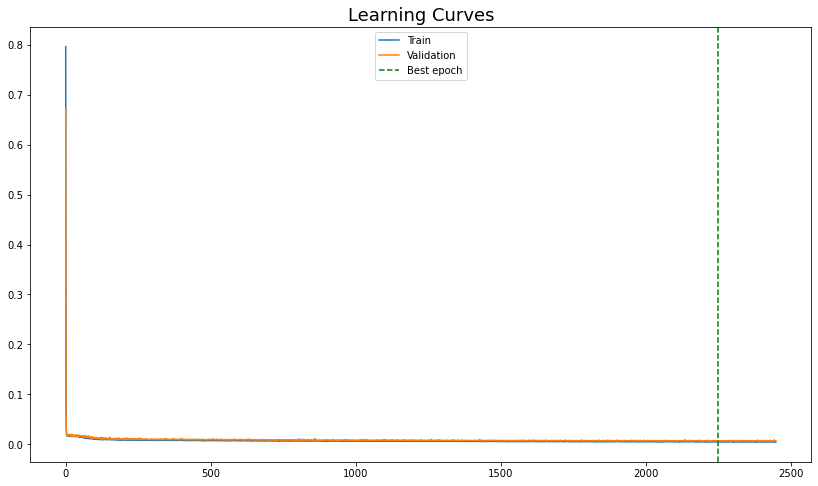

In [13]:
my_mlp = MyMLP(
    loss_function=mse, 
    output_activation_function=Identity(), 
    verbose=100
)

my_mlp.add_hidden_layer(
    n_neurons=best_params['n_neurons'], 
    activation_function=TanH()
)

my_mlp.fit(
    X=X_train_scaled, 
    y=y_train_scaled, 
    valid_set=(X_val_scaled, y_val_scaled), 
    **best_params,
    random_state=None,
    random_state_shuffle=None
)

y_train_pred = my_mlp.predict(X_train_scaled)
y_test_pred = my_mlp.predict(X_test_scaled)
y_val_pred = my_mlp.predict(X_val_scaled)

y_train_pred = y_scaler.inverse_transform(y_train_pred)
y_test_pred = y_scaler.inverse_transform(y_test_pred)
y_val_pred = y_scaler.inverse_transform(y_val_pred)

my_mlp.plot_learning_curve()

pd.concat([
    get_regression_metrics(y_train, y_train_pred, index='Training'),
    get_regression_metrics(y_test, y_test_pred, index='Test'),
    get_regression_metrics(y_val, y_val_pred, index='Validation')
])



### Trying more hidden layers

Epoch    0 -> Loss Function: Train 0.203134 | Valid 0.177436
Epoch  100 -> Loss Function: Train 0.014605 | Valid 0.017121
Epoch  200 -> Loss Function: Train 0.009190 | Valid 0.010793
Epoch  300 -> Loss Function: Train 0.009981 | Valid 0.011382
Epoch  400 -> Loss Function: Train 0.010495 | Valid 0.012188
Epoch  500 -> Loss Function: Train 0.008466 | Valid 0.010607
Epoch  600 -> Loss Function: Train 0.007842 | Valid 0.010468
Epoch  700 -> Loss Function: Train 0.008626 | Valid 0.010639
Epoch  800 -> Loss Function: Train 0.008513 | Valid 0.011073
Epoch  900 -> Loss Function: Train 0.007287 | Valid 0.010077
Epoch 1000 -> Loss Function: Train 0.006910 | Valid 0.009517
Epoch 1100 -> Loss Function: Train 0.007345 | Valid 0.009872
Epoch 1200 -> Loss Function: Train 0.006806 | Valid 0.010063
Epoch 1300 -> Loss Function: Train 0.006326 | Valid 0.009228
Epoch 1400 -> Loss Function: Train 0.006158 | Valid 0.009094
Epoch 1500 -> Loss Function: Train 0.006907 | Valid 0.009368
Epoch 1600 -> Loss Funct

,MSE,RMSE,MAE,MRE
Training,23.531823,4.850961,3.650345,0.128423
Test,38.157019,6.177137,4.524545,0.137058
Validation,39.860198,6.313493,4.566393,0.137657


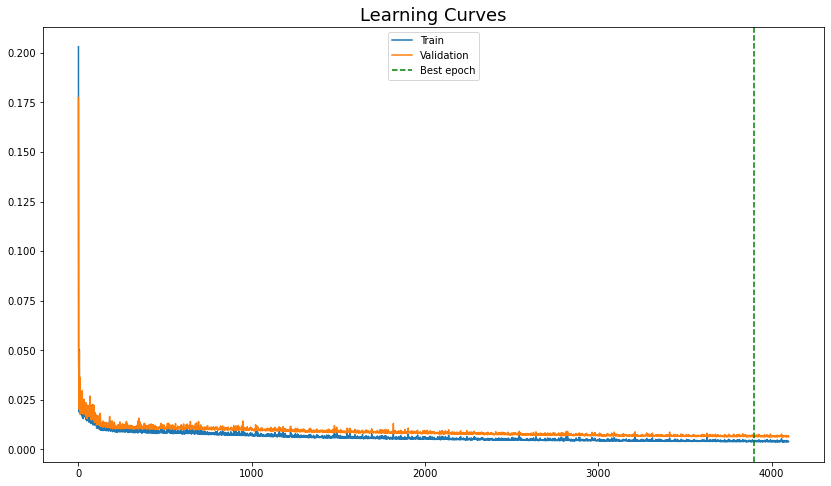

In [16]:
my_mlp = MyMLP(
    loss_function=mse, 
    output_activation_function=Identity(), 
    verbose=100
)

my_mlp.add_hidden_layer(n_neurons=50, activation_function=TanH())
my_mlp.add_hidden_layer(n_neurons=50, activation_function=TanH())


my_mlp.fit(
    X=X_train_scaled, 
    y=y_train_scaled, 
    valid_set=(X_val_scaled, y_val_scaled), 
    learning_rate=0.01,
    momentum_factor=0.9,
    early_stopping_rounds=200,
    epochs=5000,
    mini_batch=32,
    random_state=None,
    random_state_shuffle=None
)

y_train_pred = my_mlp.predict(X_train_scaled)
y_test_pred = my_mlp.predict(X_test_scaled)
y_val_pred = my_mlp.predict(X_val_scaled)

y_train_pred = y_scaler.inverse_transform(y_train_pred)
y_test_pred = y_scaler.inverse_transform(y_test_pred)
y_val_pred = y_scaler.inverse_transform(y_val_pred)

my_mlp.plot_learning_curve()

pd.concat([
    get_regression_metrics(y_train, y_train_pred, index='Training'),
    get_regression_metrics(y_test, y_test_pred, index='Test'),
    get_regression_metrics(y_val, y_val_pred, index='Validation')
])



## Testing Keras

In [17]:
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from keras.callbacks import EarlyStopping

Epoch 1738: early stopping
7/7 [==============================] - 0s 1000us/step


,MSE,RMSE,MAE,MRE
Training,27.866329,5.278857,3.931156,0.145723
Test,40.981906,6.401711,4.890819,0.157782
Validation,42.193706,6.495668,4.849641,0.158988


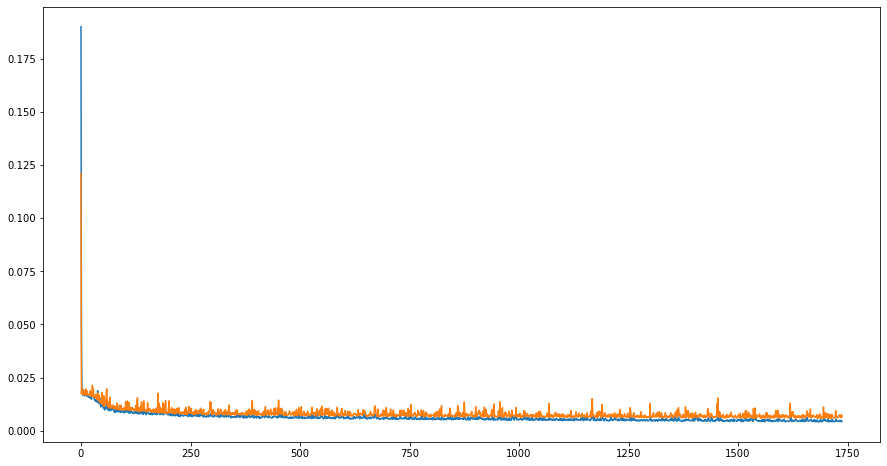

In [20]:
model = Sequential()

model.add(tf.keras.Input(shape=(8,)))
model.add(Dense(best_params['n_neurons'], activation='tanh'))
model.add(Dense(1))

model.compile(
    loss='mse', 
    optimizer=tf.keras.optimizers.SGD(
        learning_rate=best_params['learning_rate'], 
        momentum=best_params['momentum_factor']), 
    metrics=['mse'])

early_stopping_keras = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=best_params['early_stopping_rounds']

)
history = model.fit(
    X_train_scaled, 
    y_train_scaled, 
    validation_data=(X_val_scaled, y_val_scaled), 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    verbose=False, 
    callbacks=[early_stopping_keras]
)

plt.figure(figsize=(15,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)
y_val_pred = model.predict(X_val_scaled)

y_train_pred = y_scaler.inverse_transform(y_train_pred)
y_test_pred = y_scaler.inverse_transform(y_test_pred)
y_val_pred = y_scaler.inverse_transform(y_val_pred)

pd.concat([
    get_regression_metrics(y_train, y_train_pred, index='Training'),
    get_regression_metrics(y_test, y_test_pred, index='Test'),
    get_regression_metrics(y_val, y_val_pred, index='Validation')
])


## Testing Sklearn

In [21]:
from sklearn.neural_network import MLPRegressor

,MSE,RMSE,MAE,MRE
Training,28.908827,5.376693,4.231011,0.150014
Test,42.083508,6.487180,4.784988,0.143206
Validation,43.667733,6.608157,4.908286,0.157890


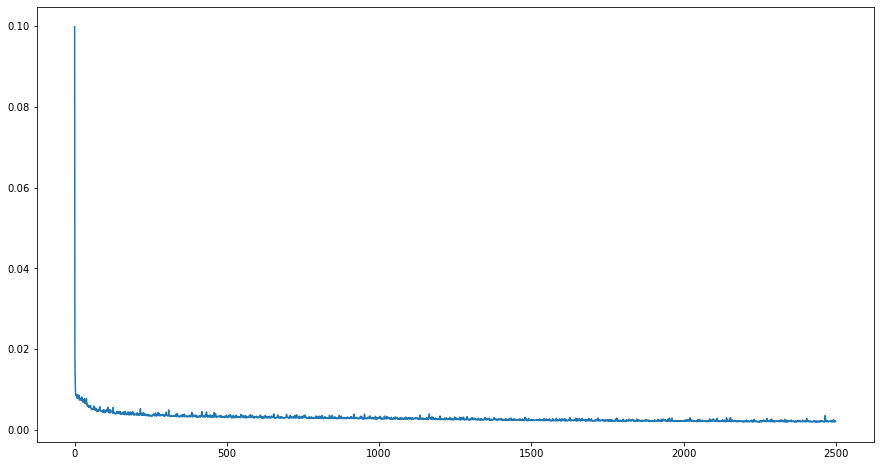

In [22]:
sk_mlp = MLPRegressor(
    hidden_layer_sizes=(best_params['n_neurons']), 
    activation='tanh', 
    solver='sgd',
    batch_size=best_params['batch_size'], 
    learning_rate="constant",
    shuffle=True,
    power_t=0,
    momentum=best_params['momentum_factor'],
    tol=0.000000001, 
    learning_rate_init=best_params['learning_rate'], 
    validation_fraction=0,
    max_iter=2500,
    n_iter_no_change=9999999,
    alpha=0,
    nesterovs_momentum=False,
    verbose=False,
    random_state=None
)
sk_mlp.fit(X_train_scaled, y_train_scaled.ravel())

plt.figure(figsize=(15,8))
plt.plot(sk_mlp.loss_curve_)

y_train_pred = sk_mlp.predict(X_train_scaled).reshape(-1, 1)
y_test_pred = sk_mlp.predict(X_test_scaled).reshape(-1, 1)
y_val_pred = sk_mlp.predict(X_val_scaled).reshape(-1, 1)

y_train_pred = y_scaler.inverse_transform(y_train_pred)
y_test_pred = y_scaler.inverse_transform(y_test_pred)
y_val_pred = y_scaler.inverse_transform(y_val_pred)

pd.concat([
    get_regression_metrics(y_train, y_train_pred, index='Training'),
    get_regression_metrics(y_test, y_test_pred, index='Test'),
    get_regression_metrics(y_val, y_val_pred, index='Validation')
])


# MLP (Classification)

In [9]:
data = np.genfromtxt('../data/vowel.csv', delimiter=',')
X = data[:, :-1]
y = data[:, -1]
print('Shape:', data.shape)
data[:3, :]


Shape: (990, 11)


array([[-3.639,  0.418, -0.67 ,  1.779, -0.168,  1.627, -0.388,  0.529,
        -0.874, -0.814,  8.   ],
       [-3.327,  0.496, -0.694,  1.365, -0.265,  1.933, -0.363,  0.51 ,
        -0.621, -0.488,  2.   ],
       [-2.12 ,  0.894, -1.576,  0.147, -0.707,  1.559, -0.579,  0.676,
        -0.809, -0.049,  1.   ]])

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 0.8, random_seed=5474
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, 0.75, random_seed=99856
)

print('Number of Rows by Split')
print('X_train: {} ({}%)'.format(X_train.shape[0], X_train.shape[0]/data.shape[0]*100))
print('X_test:  {} ({}%)'.format(X_test.shape[0], X_test.shape[0]/data.shape[0]*100))
print('X_val:   {} ({}%)'.format(X_val.shape[0], X_val.shape[0]/data.shape[0]*100))

Number of Rows by Split
X_train: 594 (60.0%)
X_test:  198 (20.0%)
X_val:   198 (20.0%)


In [11]:
X_scaler = MinMaxScaler()
X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
X_val_scaled = X_scaler.transform(X_val)

In [12]:
def one_hot_encoding(data):
    data = data.astype(int).ravel()
    data_ohe = np.zeros((data.size, data.max()+1))
    data_ohe[np.arange(data.size), data] = 1
    return data_ohe

y_train = one_hot_encoding(y_train)
y_test = one_hot_encoding(y_test)
y_val = one_hot_encoding(y_val)

print('Training:', y_train.shape)
print('Test:', y_test.shape)
print('Validation:', y_val.shape)


Training: (594, 11)
Test: (198, 11)
Validation: (198, 11)


## Selecting Parameters

In [27]:
from itertools import product
import time
import warnings
warnings.filterwarnings('ignore')
import copy

def grid_search_classification(model, params, X, y, valid_set, verbose=True):
    
    start = time.time()
    best_metric = -np.inf
    params_combination_list = list(product(*list(params.values())))

    for trial, combination in enumerate(params_combination_list):
        actual_params = {param: key for param, key in zip(
            list(params.keys()), 
            list(combination)
        )}
        
        if verbose:
            print(f'Running trial {trial+1}/{len(params_combination_list)}')
        
        instance = copy.deepcopy(model)
        
        instance.add_hidden_layer(
            n_neurons=actual_params['n_neurons'], 
            activation_function=ReLU()
        )

        instance.fit(
            X,
            y,
            valid_set=valid_set,
            **actual_params
        )

        # Getting metrics
        X_val, y_val = valid_set
        val_preds = instance.predict(X_val)
        actual_metric = accuracy(y_val, val_preds)

        if verbose:
            print('Valid Accuracy:', actual_metric, ' | Parameters:', actual_params)

        # Storing if best metric
        if actual_metric > best_metric:
            best_metric = actual_metric
            best_params = actual_params
            if verbose:
                print('New best metric!')

        trial+=1
        print('-'*50)

    end = time.time()
    print('-'*50)
    print('Grid Search Completed in ', round(end - start, 4), 'seconds')
    print('Selected parameters:')
    print(best_params)

    return best_params


# Trying only basic parameters in order not to slow down the training
params = {
    'learning_rate': [0.1, 0.01],
    'momentum_factor': [0.5, 0.9],
    'early_stopping_rounds': [200],
    'n_neurons': [20, 50],
    'epochs': [5000], # Fixed because the early_stopping_rounds was set
    'batch_size': [4, 32]
}

my_mlp = MyMLP(
    loss_function=cross_entropy_loss,
    output_activation_function=Softmax(), 
    verbose=False
)

best_params = grid_search_classification(
    my_mlp, 
    params,
    X=X_train_scaled, 
    y=y_train, 
    valid_set=(X_val_scaled, y_val),
    verbose=True    
)

Running trial 1/16
-> Early stopping has been activated! Best epoch: 89
Valid Accuracy: 0.7373737373737373  | Parameters: {'learning_rate': 0.1, 'momentum_factor': 0.5, 'early_stopping_rounds': 200, 'n_neurons': 20, 'epochs': 5000, 'batch_size': 4}
New best metric!
--------------------------------------------------
Running trial 2/16
-> Early stopping has been activated! Best epoch: 773
Valid Accuracy: 0.8737373737373737  | Parameters: {'learning_rate': 0.1, 'momentum_factor': 0.5, 'early_stopping_rounds': 200, 'n_neurons': 20, 'epochs': 5000, 'batch_size': 32}
New best metric!
--------------------------------------------------
Running trial 3/16
-> Early stopping has been activated! Best epoch: 454
Valid Accuracy: 0.9292929292929293  | Parameters: {'learning_rate': 0.1, 'momentum_factor': 0.5, 'early_stopping_rounds': 200, 'n_neurons': 50, 'epochs': 5000, 'batch_size': 4}
New best metric!
--------------------------------------------------
Running trial 4/16
-> Early stopping has been 

## Training

Epoch    0 -> Loss Function: Train 2.397414 | Valid 2.385573
Epoch  100 -> Loss Function: Train 0.158502 | Valid 0.337458
Epoch  200 -> Loss Function: Train 0.024456 | Valid 0.228218
Epoch  300 -> Loss Function: Train 0.011211 | Valid 0.215891
Epoch  400 -> Loss Function: Train 0.006905 | Valid 0.224602
-> Early stopping has been activated! Best epoch: 297


,Accuracy
Training,1.000000
Test,0.934343
Validation,0.939394


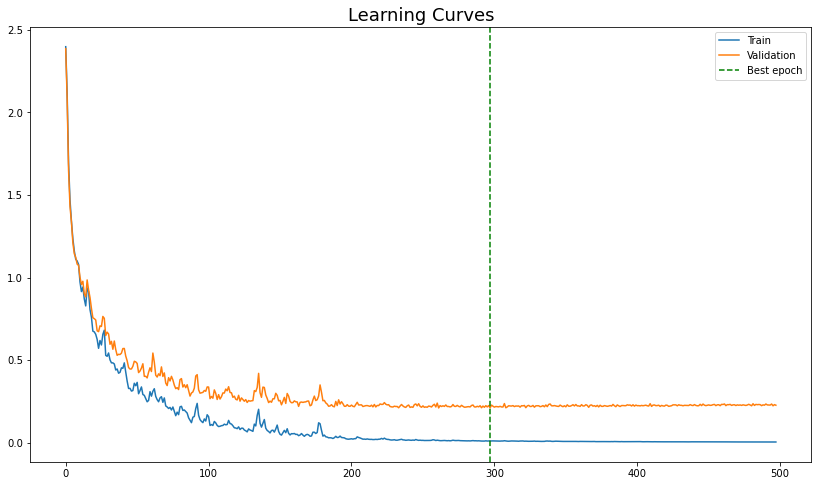

In [28]:
my_mlp = MyMLP(
    loss_function=cross_entropy_loss,
    output_activation_function=Softmax(), 
    verbose=100
)
my_mlp.add_hidden_layer(n_neurons=best_params['n_neurons'], activation_function=ReLU())
my_mlp.fit(
    X=X_train_scaled, 
    y=y_train,
    valid_set=(X_val_scaled, y_val), 
    **best_params,
    # epochs=500,
    random_state=None,
    random_state_shuffle=None
)

y_train_pred = my_mlp.predict(X_train_scaled)
y_test_pred = my_mlp.predict(X_test_scaled)
y_val_pred = my_mlp.predict(X_val_scaled)

my_mlp.plot_learning_curve()
pd.concat([
    get_classification_metrics(y_train, y_train_pred, index='Training'),
    get_classification_metrics(y_test, y_test_pred, index='Test'),
    get_classification_metrics(y_val, y_val_pred, index='Validation')
])



## Trying more hidden layers

Epoch    0 -> Loss Function: Train 2.386352 | Valid 2.368800
Epoch  100 -> Loss Function: Train 0.166992 | Valid 0.438462
Epoch  200 -> Loss Function: Train 0.211132 | Valid 0.544672
Epoch  300 -> Loss Function: Train 0.014706 | Valid 0.208146
Epoch  400 -> Loss Function: Train 0.000666 | Valid 0.252107
-> Early stopping has been activated! Best epoch: 298


,Accuracy
Training,1.000000
Test,0.949495
Validation,0.919192


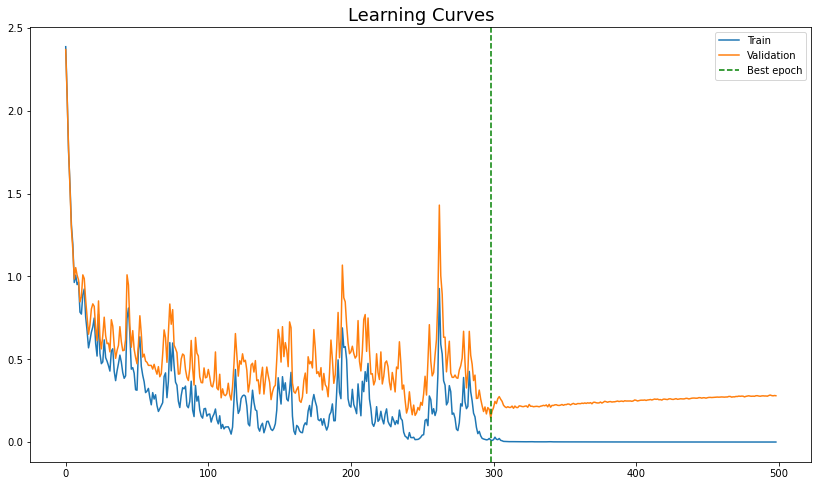

In [37]:
my_mlp = MyMLP(
    loss_function=cross_entropy_loss,
    output_activation_function=Softmax(), 
    verbose=100
)

my_mlp.add_hidden_layer(n_neurons=40, activation_function=ReLU())
my_mlp.add_hidden_layer(n_neurons=20, activation_function=ReLU())

my_mlp.fit(
    X=X_train_scaled, 
    y=y_train,
    valid_set=(X_val_scaled, y_val), 
    learning_rate=0.1,
    momentum_factor=0.9,
    early_stopping_rounds=200,
    epochs=5000,
    mini_batch=32,
    random_state=None,
    random_state_shuffle=None
)

y_train_pred = my_mlp.predict(X_train_scaled)
y_test_pred = my_mlp.predict(X_test_scaled)
y_val_pred = my_mlp.predict(X_val_scaled)

my_mlp.plot_learning_curve()
pd.concat([
    get_classification_metrics(y_train, y_train_pred, index='Training'),
    get_classification_metrics(y_test, y_test_pred, index='Test'),
    get_classification_metrics(y_val, y_val_pred, index='Validation')
])



## Testing Keras

In [29]:
from keras.models import Sequential, Model
from keras.layers import Dense, Input
import keras
import tensorflow as tf
from keras.callbacks import EarlyStopping

Epoch 3804: early stopping
7/7 [==============================] - 0s 2ms/step


,Accuracy
Training,0.978114
Test,0.898990
Validation,0.898990


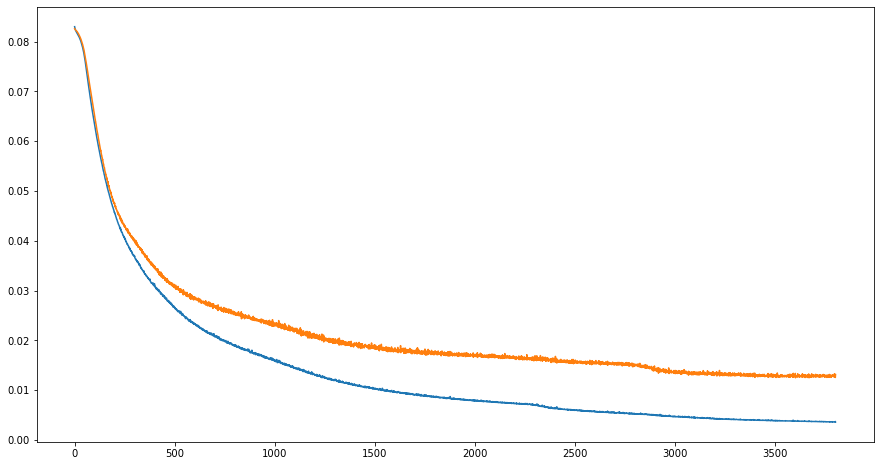

In [41]:
model = Sequential()

model.add(tf.keras.Input(shape=(10,)))
model.add(Dense(best_params['n_neurons'], activation='relu'))
model.add(Dense(11, activation='softmax'))

model.compile(
    loss='mse', 
    optimizer=tf.keras.optimizers.SGD(
        learning_rate=best_params['learning_rate'], 
        momentum=best_params['momentum_factor']), 
    metrics=['mse'])

early_stopping_keras = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=best_params['early_stopping_rounds']
)
history = model.fit(
    X_train_scaled, 
    y_train, 
    validation_data=(X_val_scaled, y_val), 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    verbose=False, 
    callbacks=[early_stopping_keras]
)

plt.figure(figsize=(15,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

y_train_pred = one_hot_encoding(np.argmax(model.predict(X_train_scaled), axis=1))
y_test_pred = one_hot_encoding(np.argmax(model.predict(X_test_scaled), axis=1))
y_val_pred = one_hot_encoding(np.argmax(model.predict(X_val_scaled), axis=1))

pd.concat([
    get_classification_metrics(y_train, y_train_pred, index='Training'),
    get_classification_metrics(y_test, y_test_pred, index='Test'),
    get_classification_metrics(y_val, y_val_pred, index='Validation')
])



## Testing Sklearn

In [12]:
from sklearn.neural_network import MLPClassifier

c:\Users\edyalenquer\.conda\envs\ml-project\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:706: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  if self.n_iter_ == self.max_iter:


,Accuracy
Training,1.000000
Test,0.924242
Validation,0.909091


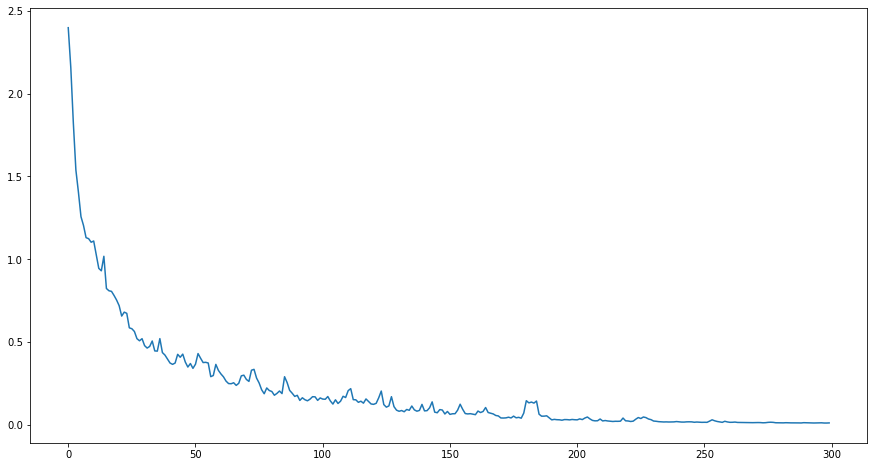

In [24]:
sk_mlp = MLPClassifier(
    hidden_layer_sizes=(best_params['n_neurons']), 
    activation='relu', 
    solver='sgd',
    batch_size=best_params['batch_size'], 
    learning_rate="constant",
    shuffle=True,
    power_t=0,
    momentum=best_params['momentum_factor'],
    tol=0.000000001, 
    learning_rate_init=best_params['learning_rate'], 
    validation_fraction=0,
    max_iter=300,
    n_iter_no_change=9999999,
    alpha=0,
    nesterovs_momentum=False,
    verbose=False,
    random_state=None
)

sk_mlp.fit(X_train_scaled, y_train)

plt.figure(figsize=(15,8))
plt.plot(sk_mlp.loss_curve_)


y_train_pred = sk_mlp.predict(X_train_scaled)
y_test_pred = sk_mlp.predict(X_test_scaled)
y_val_pred = sk_mlp.predict(X_val_scaled)

pd.concat([
    get_classification_metrics(y_train, y_train_pred, index='Training'),
    get_classification_metrics(y_test, y_test_pred, index='Test'),
    get_classification_metrics(y_val, y_val_pred, index='Validation')
])
